# Pneumonia X-Ray Image Classification

# Overview
---
<img src='images/lung.png' width=300 align='right'/>
<br>
Pneumonia is an infection that inflames the air sacs in our lungs. Many germs can cause pneumonia -- the most common are bacteria and viruses in the air we breathe. Your body usually prevents these germs from infecting your lungs, but sometimes these germs can overpower your immune system, even if your health is generally good. Pneumonia is the world’s leading cause of death among children under 5 years of age.

An x-ray exam will allow your doctor to see your lungs, heart and blood vessels to help determine if you have pneumonia. When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection.

Using Convolutional Neural Networks we can train a model that identifies whether a patient has pneumonia given a chest x-ray. Our final model has a 95% accuracy on our testing images. 


# Business Understanding
---
Machine Learning has shown impressive accuracy in medical imaging. Creating a predictive model for identifying pneumonia from x-ray images provides medical professionals with a system that can automate the process for accurate identification of pneumonia, saving time and resources. 

As with many predictive models used in medicine, we would rather minimize false negatives (patient has pnumonia but the model classifies their x-ray as normal) than false positives (patient doesn't have pnumonia but the model classifies x-ray as pnumonia). This is because we are dealing with the lives and health of humans. Therefore we want to create a model that minimizes false negatives.

# Data Understanding
---
This dataset contains 5,856 validated Chest X-Ray images. The images categorized into two subsets -- Pneumonia and Normal. The images are split into training, validation, and testing sets. 

This dataset comes from Kermany et al and can be found at https://data.mendeley.com/datasets/rscbjbr9sj/3

All x-rays were initially screened for quality control and graded by three expert physicians before being cleared for training the AI system.




# Data Preparation

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os, shutil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
test_folder = 'data/chest_xray/test/'
train_folder = 'data/chest_xray/train/' 

val_folder = 'data/chest_xray/val/'

In [3]:
train_pneu = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_pneu = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_pneu = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [4]:
print(f'There are {len(os.listdir(test_normal))} normal images and {len(os.listdir(test_pneu))} phneumonia images in the test folder')

print(f'There are {len(os.listdir(train_normal))} normal images and {len(os.listdir(train_pneu))} phneumonia images in the train folder')


There are 235 normal images and 390 phneumonia images in the test folder
There are 1147 normal images and 3302 phneumonia images in the train folder


#### Redistribute images from train to validation

In [5]:
# # create directory in data folder. Uncomment to instantiate. commented out because already exists

# os.mkdir(val_folder)

In [6]:
# create directories for PNEUMONIA and NORMAL in the validation folder
# val_pneu = os.path.join(val_folder, 'PNEUMONIA')
# val_normal = os.path.join(val_folder, 'NORMAL')

In [7]:
# # uncomment to instantiate directories

# os.mkdir(val_pneu)
# os.mkdir(val_normal)

In [8]:
# # randomly take a selection of images from train pneumonia to val pneumonia. Chose 15% for split
# # Commented out after initial split
# source = train_pneu
# dest = val_pneu
# files = os.listdir(source)
# no_of_files = int(len(files)*0.15)

# for file_name in random.sample(files, no_of_files):
#     shutil.move(os.path.join(source, file_name), dest)

In [9]:
# # randomly take a selection of images from train normal to val normal. Chose 15% for split. 
# # Commented out after initial split
# source = train_normal
# dest = val_normal
# files = os.listdir(source)
# no_of_files = int(len(files)*0.15)

# for file_name in random.sample(files, no_of_files):
#     shutil.move(os.path.join(source, file_name), dest)

In [10]:
print(f'There are {len(os.listdir(val_normal))} normal images and {len(os.listdir(val_pneu))} phneumonia images in the validation folder')

print(f'There are {len(os.listdir(test_normal))} normal images and {len(os.listdir(test_pneu))} phneumonia images in the test folder')

print(f'There are {len(os.listdir(train_normal))} normal images and {len(os.listdir(train_pneu))} phneumonia images in the train folder')


There are 202 normal images and 582 phneumonia images in the validation folder
There are 235 normal images and 390 phneumonia images in the test folder
There are 1147 normal images and 3302 phneumonia images in the train folder


#### We are aiming for a 70, 15, 15 split between train, test, val which is right around where we are. Now that we have a good distribution of images in each directory we can prepare them for modeling

In [11]:
# create generators for each folder

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(250, 250), batch_size = 64) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(250, 250), batch_size = 64)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(250, 250), batch_size=64)

Found 624 images belonging to 2 classes.
Found 783 images belonging to 2 classes.
Found 4449 images belonging to 2 classes.


In [12]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [13]:
train_images.shape

(64, 250, 250, 3)

In [14]:
print ("Shape of training images: " + str(train_images.shape))
print ("Shape of testing images: " + str(test_images.shape))
print ("Shape of validation images: " + str(val_images.shape))

Shape of training images: (64, 250, 250, 3)
Shape of testing images: (64, 250, 250, 3)
Shape of validation images: (64, 250, 250, 3)


In [15]:
print ("Shape of training labels: " + str(train_labels.shape))
print ("Shape of testing labels: " + str(test_labels.shape))
print ("Shape of validation labels: " + str(val_labels.shape))

Shape of training labels: (64, 2)
Shape of testing labels: (64, 2)
Shape of validation labels: (64, 2)


In [16]:
train_labels[:10]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
# first index is normal, second is pneumonia
val_labels[0]

array([0., 1.], dtype=float32)

array([1., 0.], dtype=float32)

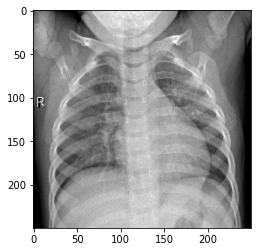

In [18]:
# sample image from the train set of pneumonia x-ray
plt.imshow(train_images[0])
train_labels[0]

array([1., 0.], dtype=float32)

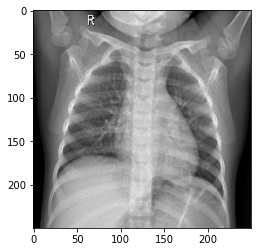

In [19]:
# sample image from the train set of normal x-ray
plt.imshow(train_images[5])
train_labels[5]

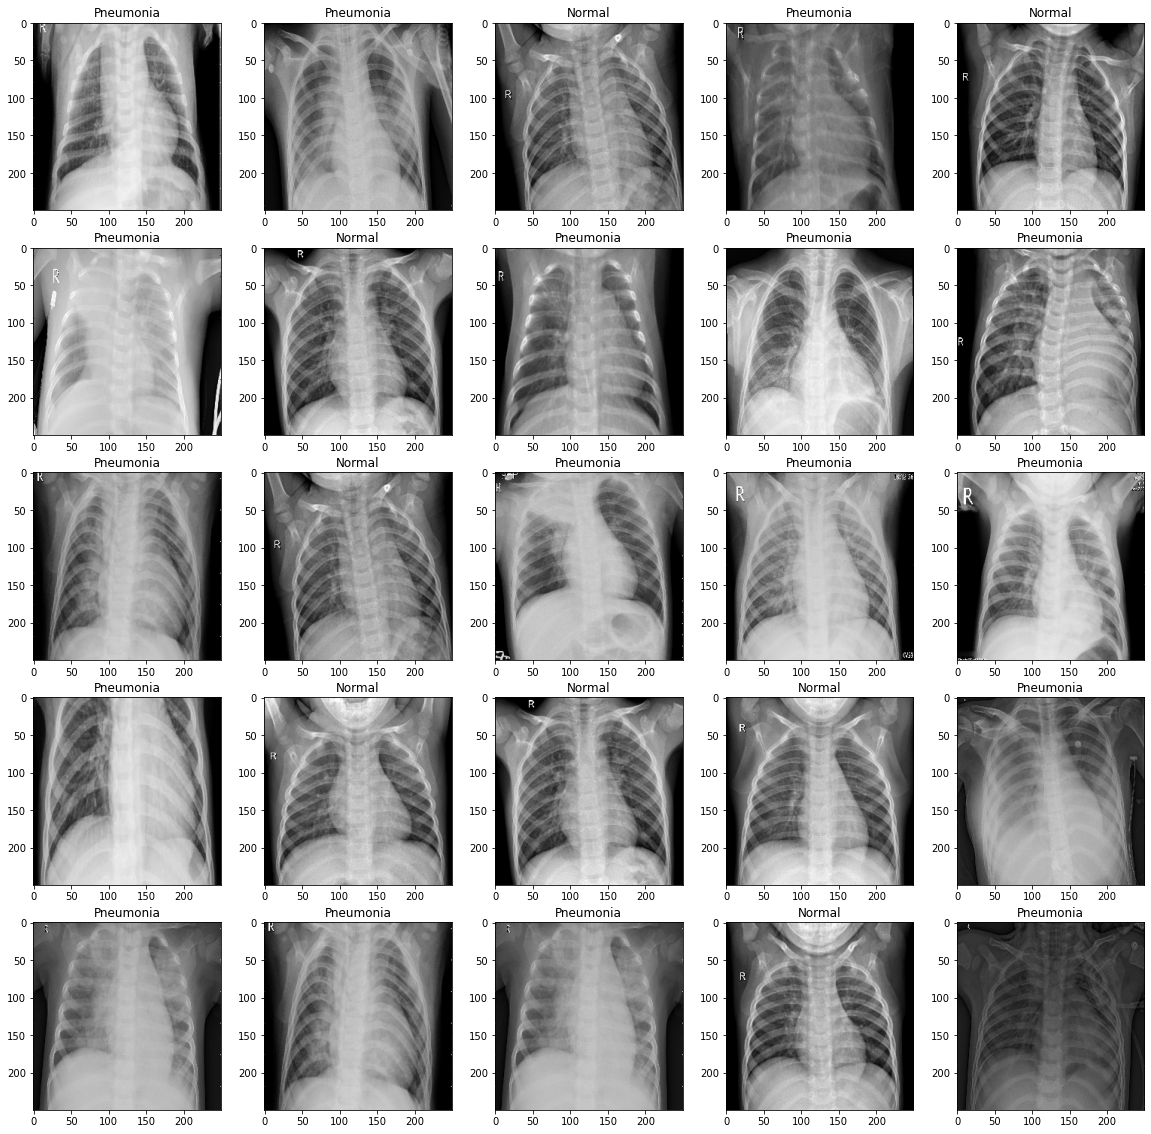

In [20]:
# plot 25 random photos of normal and pneumonia x-rays so we can get an idea of what our model is looking for 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))

for x in range(0,5):
    for y in range(0, 5):
        i = np.random.randint(0,len(train_images))
        axes[x][y].imshow(train_images[i])
        
        if train_labels[i][0] == 0:
            axes[x][y].set_title('Pneumonia')
        else:
            axes[x][y].set_title('Normal')

### Reshape train, test, val images and labels

In [21]:
X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)
X_val = val_images.reshape(val_images.shape[0], -1)

In [22]:
train_images.shape

(64, 250, 250, 3)

In [23]:
X_train.shape

(64, 187500)

In [24]:
y_train = np.reshape(train_labels[:, 0], (train_labels.shape[0], 1))
y_test = np.reshape(test_labels[:, 0], (test_labels.shape[0], 1))
y_val = np.reshape(val_labels[:, 0], (val_labels.shape[0], 1))

In [25]:
y_train.shape

(64, 1)

### Functions for Plotting

In [26]:
# function takes y_pred and y_true and plots confusion matrix
def plot_confusion_matrix(model, y_true, y_images):
    predictions = model.predict(y_images)
    y_pred = np.round(predictions, 0)
    y_pred = np.reshape(y_pred, -1)

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()
    
    print(classification_report(y_true, y_pred))

In [27]:
# function plots the accuracy and loss of the train and val over epochs
def plot_model(results):
    
    history=results.history

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    ax1.plot(history['loss'], label='Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.grid(False)
    ax1.legend()

    ax2.plot(history['acc'], label = 'Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.grid(False)
    ax2.legend();

# Data Modeling

### Baseline Model (Non Convolutional)
We will start with a basic Neural Network model with 2 hidden layers to get a baseline score

In [28]:
baseline = Sequential()

baseline.add(layers.Dense(32, activation='relu', input_shape=(187500,)))
baseline.add(layers.Dense(64, activation='relu'))
baseline.add(layers.Dense(64, activation='relu'))

baseline.add(layers.Dense(1, activation='sigmoid'))

In [29]:
baseline.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [30]:
baseline_results = baseline.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/32
2/2 [==============================] - 0s 76ms/step - loss: 14.9747 - acc: 0.7188 - val_loss: 13.3277 - val_acc: 0.7188
Epoch 2/32
2/2 [==============================] - 0s 23ms/step - loss: 9.6214 - acc: 0.7188 - val_loss: 2.2717 - val_acc: 0.2812
Epoch 3/32
2/2 [==============================] - 0s 21ms/step - loss: 1.5925 - acc: 0.4688 - val_loss: 0.4570 - val_acc: 0.7344
Epoch 4/32
2/2 [==============================] - 0s 22ms/step - loss: 1.0953 - acc: 0.4688 - val_loss: 1.2929 - val_acc: 0.7188
Epoch 5/32
2/2 [==============================] - 0s 22ms/step - loss: 1.4347 - acc: 0.7188 - val_loss: 1.4762 - val_acc: 0.7188
Epoch 6/32
2/2 [==============================] - 0s 20ms/step - loss: 0.8945 - acc: 0.7188 - val_loss: 0.8356 - val_acc: 0.5156
Epoch 7/32
2/2 [==============================] - 0s 22ms/step - loss: 0.6623 - acc: 0.6719 - val_loss: 0.4672 - val_acc: 0.7188
Epoch 8/32
2/2 [==============================] - 0s 22ms/step - loss: 0.4901 - acc: 0.7812 - v

In [31]:
results_test = baseline.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.4674 - acc: 0.8750


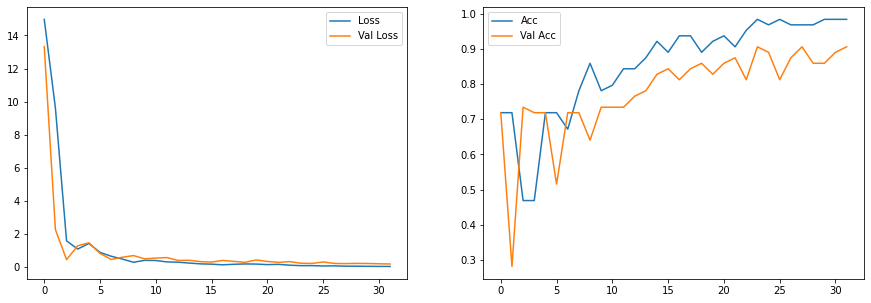

In [32]:
plot_model(baseline_results)

#### The baseline model shows a relatively high training accuracy and low loss. Lets take a look at some Convolutional Neural Network's to see if we can improve that score even higher. We will start with a basline, untuned, model

### CNN Baseline
This is a basline Convolutional Neural Network model without any dropout or regularization. We have increased the number of hidden layers to 3

In [33]:
cnn_baseline = Sequential()

cnn_baseline.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))

cnn_baseline.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_baseline.add(layers.MaxPooling2D((2, 2)))

cnn_baseline.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_baseline.add(layers.MaxPooling2D((2,2)))

cnn_baseline.add(layers.Flatten())
cnn_baseline.add(layers.Dense(64, activation='relu'))
cnn_baseline.add(layers.Dense(1, activation='sigmoid'))

In [34]:
cnn_baseline.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [35]:
cnn_baseline_results = cnn_baseline.fit(train_images, y_train, epochs=30, batch_size=32,  validation_data=(val_images, y_val), verbose=1)


Epoch 1/30
2/2 [==============================] - 1s 671ms/step - loss: 1.0760 - acc: 0.5469 - val_loss: 0.8420 - val_acc: 0.2812
Epoch 2/30
2/2 [==============================] - 1s 677ms/step - loss: 0.7026 - acc: 0.5000 - val_loss: 0.5760 - val_acc: 0.7188
Epoch 3/30
2/2 [==============================] - 1s 699ms/step - loss: 0.5612 - acc: 0.7188 - val_loss: 0.5785 - val_acc: 0.7188
Epoch 4/30
2/2 [==============================] - 1s 633ms/step - loss: 0.5709 - acc: 0.7344 - val_loss: 0.5562 - val_acc: 0.7188
Epoch 5/30
2/2 [==============================] - 1s 663ms/step - loss: 0.5091 - acc: 0.7188 - val_loss: 0.5094 - val_acc: 0.7188
Epoch 6/30
2/2 [==============================] - 1s 619ms/step - loss: 0.4656 - acc: 0.8438 - val_loss: 0.4413 - val_acc: 0.7812
Epoch 7/30
2/2 [==============================] - 1s 656ms/step - loss: 0.3964 - acc: 0.7969 - val_loss: 0.3864 - val_acc: 0.7812
Epoch 8/30
2/2 [==============================] - 1s 689ms/step - loss: 0.3073 - acc: 0.89

In [36]:
results_test = cnn_baseline.evaluate(test_images, y_test)

2/2 [==============================] - 0s 120ms/step - loss: 1.5637 - acc: 0.8281


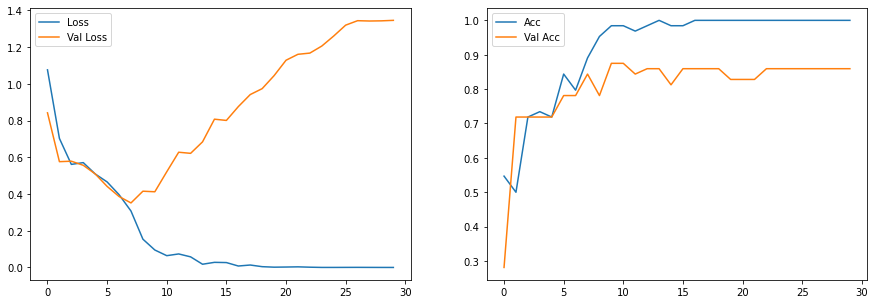

In [37]:
plot_model(cnn_baseline_results)

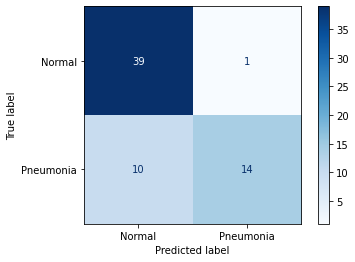

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88        40
         1.0       0.93      0.58      0.72        24

    accuracy                           0.83        64
   macro avg       0.86      0.78      0.80        64
weighted avg       0.85      0.83      0.82        64



In [38]:
plot_confusion_matrix(cnn_baseline, y_test, test_images)

#### Test accuracy remains in the same range as our baseline model, but our validation loss is relatively poor. We can see from our results though that we are majorly overfitting on our training data. Lets do some more parameter tuning by using Dropout to see if we can reduce that overfitting

### CNN Tuned
This is a CNN model with dropout. We will continue to use the same number of hidden layers though

In [39]:
cnn_tune = Sequential()

cnn_tune.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)))
cnn_tune.add(layers.MaxPooling2D((2, 2)))

cnn_tune.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_tune.add(layers.MaxPooling2D((2, 2)))
cnn_tune.add(layers.Dropout(0.2))

cnn_tune.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_tune.add(layers.MaxPooling2D((2,2)))

cnn_tune.add(layers.Flatten())
cnn_tune.add(layers.Dense(64, activation='relu'))
cnn_tune.add(layers.Dense(1, activation='sigmoid'))

In [40]:
cnn_tune.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [41]:
cnn_tune_results = cnn_tune.fit(train_images, y_train, epochs=30, validation_data=(val_images, y_val), verbose=1)


Epoch 1/30
2/2 [==============================] - 1s 694ms/step - loss: 1.7074 - acc: 0.5312 - val_loss: 0.6970 - val_acc: 0.7188
Epoch 2/30
2/2 [==============================] - 1s 683ms/step - loss: 0.8820 - acc: 0.7188 - val_loss: 0.6875 - val_acc: 0.8125
Epoch 3/30
2/2 [==============================] - 1s 734ms/step - loss: 0.6842 - acc: 0.7500 - val_loss: 0.6704 - val_acc: 0.7188
Epoch 4/30
2/2 [==============================] - 1s 701ms/step - loss: 0.6227 - acc: 0.7188 - val_loss: 0.6097 - val_acc: 0.7188
Epoch 5/30
2/2 [==============================] - 1s 646ms/step - loss: 0.5806 - acc: 0.7188 - val_loss: 0.5787 - val_acc: 0.7188
Epoch 6/30
2/2 [==============================] - 1s 686ms/step - loss: 0.5677 - acc: 0.7188 - val_loss: 0.5818 - val_acc: 0.7188
Epoch 7/30
2/2 [==============================] - 1s 670ms/step - loss: 0.5253 - acc: 0.7188 - val_loss: 0.5657 - val_acc: 0.7188
Epoch 8/30
2/2 [==============================] - 1s 667ms/step - loss: 0.4489 - acc: 0.73

In [42]:
results_test = cnn_tune.evaluate(test_images, y_test)

2/2 [==============================] - 0s 113ms/step - loss: 1.3523 - acc: 0.8281


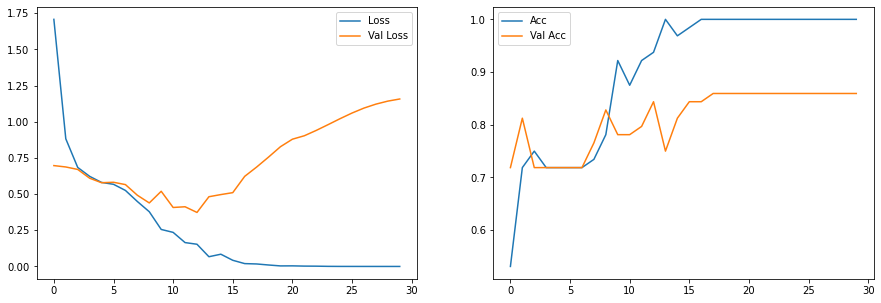

In [43]:
plot_model(cnn_tune_results)

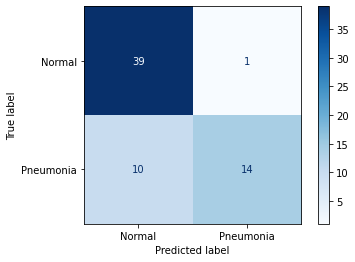

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88        40
         1.0       0.93      0.58      0.72        24

    accuracy                           0.83        64
   macro avg       0.86      0.78      0.80        64
weighted avg       0.85      0.83      0.82        64



In [44]:
plot_confusion_matrix(cnn_tune, y_test, test_images)

#### We can see that we have improved on our loss value but our score remains relatively the same. Our model still seems to be overfitting quite a bit so lets add in some regularizations.

### CNN With Regularizations
This model adds regularizers to each layer but keeps everything else the same

In [45]:
cnn_tune1 = Sequential()

cnn_tune1.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(250,250,3)))
cnn_tune1.add(layers.MaxPooling2D((2, 2)))

cnn_tune1.add(layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'))
cnn_tune1.add(layers.MaxPooling2D((2, 2)))
cnn_tune1.add(layers.Dropout(0.2))

cnn_tune1.add(layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'))
cnn_tune1.add(layers.MaxPooling2D((2,2)))

cnn_tune1.add(layers.Flatten())
cnn_tune1.add(layers.Dense(64, activation='relu'))
cnn_tune1.add(layers.Dense(1, activation='sigmoid'))

In [46]:
cnn_tune1.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [47]:
cnn_tune1_results = cnn_tune1.fit(train_images, y_train, epochs=50, batch_size=150, validation_data=(val_images, y_val), verbose=1)


Epoch 1/50
1/1 [==============================] - 1s 557ms/step - loss: 1.8245 - acc: 0.3594 - val_loss: 2.1471 - val_acc: 0.7188
Epoch 2/50
1/1 [==============================] - 0s 462ms/step - loss: 2.8143 - acc: 0.7188 - val_loss: 1.6607 - val_acc: 0.7188
Epoch 3/50
1/1 [==============================] - 0s 453ms/step - loss: 1.6908 - acc: 0.7188 - val_loss: 1.7179 - val_acc: 0.7188
Epoch 4/50
1/1 [==============================] - 0s 468ms/step - loss: 1.6856 - acc: 0.7188 - val_loss: 1.6886 - val_acc: 0.7188
Epoch 5/50
1/1 [==============================] - 0s 489ms/step - loss: 1.6479 - acc: 0.7188 - val_loss: 1.6185 - val_acc: 0.7188
Epoch 6/50
1/1 [==============================] - 0s 469ms/step - loss: 1.5598 - acc: 0.7188 - val_loss: 1.5506 - val_acc: 0.7188
Epoch 7/50
1/1 [==============================] - 0s 465ms/step - loss: 1.6008 - acc: 0.7188 - val_loss: 1.5358 - val_acc: 0.7188
Epoch 8/50
1/1 [==============================] - 0s 455ms/step - loss: 1.5149 - acc: 0.71

In [48]:
results_test = cnn_tune1.evaluate(test_images, y_test)

2/2 [==============================] - 0s 117ms/step - loss: 1.0459 - acc: 0.8125


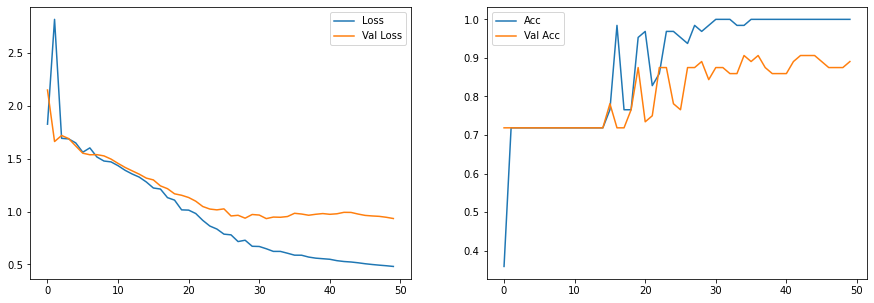

In [49]:
plot_model(cnn_tune1_results)

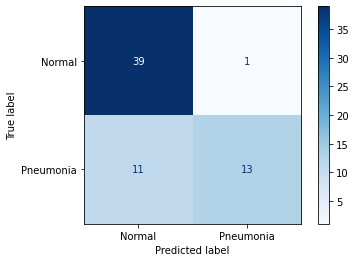

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87        40
         1.0       0.93      0.54      0.68        24

    accuracy                           0.81        64
   macro avg       0.85      0.76      0.78        64
weighted avg       0.84      0.81      0.80        64



In [50]:
plot_confusion_matrix(cnn_tune1, y_test, test_images)

#### We have decreased our loss scores from the use of regularizations but we have not reduced our overfitting. Lets try some augmentation using ImageDataGenerator. 

### Augmentation
Now we will use ImageDataGenerator to generate some more data for our model training. Tuning showed that using shear_range, zoom_range, and horizontal_flip highly were the most effective. Also decreasing image size and batch size.

In [51]:
val_generator_aug = ImageDataGenerator(rescale=1./255,shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True).flow_from_directory(
        val_folder, 
        target_size=(150, 150), batch_size = 32, class_mode='binary')

train_generator_aug = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True).flow_from_directory(
        train_folder, 
        target_size=(150, 150), batch_size=32, class_mode='binary')


test_generator_aug = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(150, 150), batch_size=624, class_mode='binary')


Found 783 images belonging to 2 classes.
Found 4449 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [52]:
train_images_gen, train_labels_gen = next(train_generator_aug)
test_images_gen, test_labels_gen = next(test_generator_aug)
val_images_gen, val_labels_gen = next(val_generator_aug)

In [53]:
augment = Sequential()

augment.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
augment.add(layers.MaxPooling2D((2, 2)))

augment.add(layers.Conv2D(64, (3,3), activation='relu'))
augment.add(layers.MaxPooling2D((2, 2)))
augment.add(layers.Dropout(0.2))

augment.add(layers.Conv2D(64, (3,3), activation='relu'))
augment.add(layers.MaxPooling2D((2,2)))

augment.add(layers.Flatten())
augment.add(layers.Dense(64, activation='relu'))
augment.add(layers.Dense(1, activation='sigmoid'))

In [54]:
augment.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [55]:
augment_results = augment.fit(train_generator_aug, epochs=30, validation_data=val_generator_aug, verbose=1)

Epoch 1/30
140/140 [==============================] - 101s 719ms/step - loss: 0.3992 - acc: 0.8152 - val_loss: 0.2056 - val_acc: 0.9234
Epoch 2/30
140/140 [==============================] - 90s 642ms/step - loss: 0.2684 - acc: 0.8921 - val_loss: 0.2220 - val_acc: 0.9068
Epoch 3/30
140/140 [==============================] - 96s 688ms/step - loss: 0.2288 - acc: 0.9103 - val_loss: 0.1662 - val_acc: 0.9298
Epoch 4/30
140/140 [==============================] - 97s 693ms/step - loss: 0.2087 - acc: 0.9222 - val_loss: 0.1722 - val_acc: 0.9425
Epoch 5/30
140/140 [==============================] - 99s 704ms/step - loss: 0.1920 - acc: 0.9290 - val_loss: 0.1589 - val_acc: 0.9374
Epoch 6/30
140/140 [==============================] - 102s 728ms/step - loss: 0.1768 - acc: 0.9308 - val_loss: 0.1591 - val_acc: 0.9502
Epoch 7/30
140/140 [==============================] - 102s 727ms/step - loss: 0.1698 - acc: 0.9319 - val_loss: 0.1366 - val_acc: 0.9489
Epoch 8/30
140/140 [==============================] 

In [56]:
augment_results_test = augment.evaluate(test_generator_aug)

1/1 [==============================] - 0s 1ms/step - loss: 0.1888 - acc: 0.9311


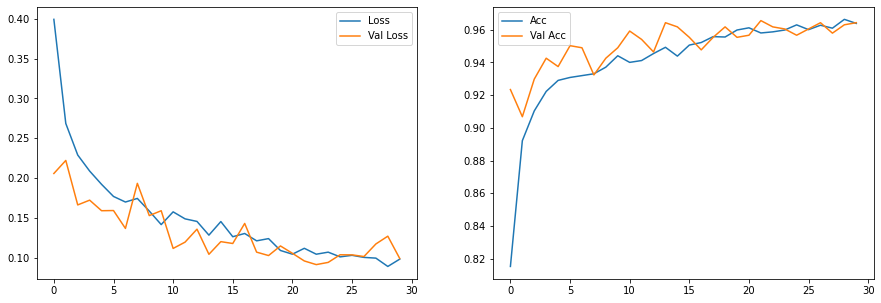

In [57]:
plot_model(augment_results)

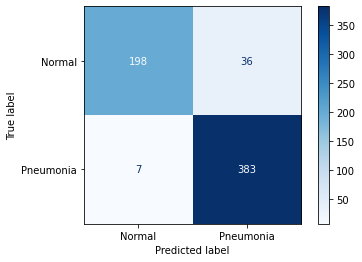

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90       234
         1.0       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [58]:
plot_confusion_matrix(augment, test_labels_gen, test_images_gen)

In [59]:
# use this code to save model to avoid needing to re-run
# augment.save('data/models/augment_model.h5')

In [67]:
saved_augment = tf.keras.models.load_model('data/models/augment_model.h5')

In [61]:
# with open('data/models/augment_history', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

### Using augmentation and ImageDataGenerator we have significantly increased our test score, reduced our loss score, as well as reduced any overfitting from our original models. We can see that this model also does a much better job at reducing our false negative classifications. This is a significant improvement and we will consider it to be our final model

### Because CNN models do not allow the use of a random seed for consistency, our model's metrics changed based on each run. All the scores ranged between 93% and 96% accuracy. For consistancy purpose we have saved a model using tensorflow's save and load model functions and below we will load our saved model

# Evaluation

In [69]:
results_test = saved_augment.evaluate(test_generator_aug)

1/1 [==============================] - 0s 1ms/step - loss: 0.1169 - acc: 0.9599


<img src='images/augment_plot.png' />

In [70]:
saved_augment.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)       

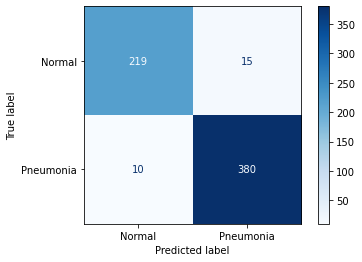

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       234
         1.0       0.96      0.97      0.97       390

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



In [73]:
plot_confusion_matrix(saved_augment, test_labels_gen, test_images_gen)

# Conclusion
---

Our final model has an accuracy of 95% on predicting whether an x-ray image contains evidence of Pneumonia (viral or bacterial). As we can see from our confusion matrix, our model shows to classify more false positives ('classifies as pnumonia, but not') than false negatives ('classifies as normal, but actually pneumonia'). This alligns strongly with our business problem so we will consider this model to be very efficient in classifying pneumonia from chest x-rays.

# Next Steps
---

This type of methodology can be extremely useful in the identification of infections and adnormalities in medical imaging (not just x-ray but MRI, CT's, etc..). The use of maching learning techniques has the potential to be extremely useful in the medical field, but it also has the potential to be harmful. We have to be mindful with the types of scenarios we are using maching learning and AI for and be socially responsible when diploying models. 